In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os
from operator import itemgetter
from itertools import groupby

#optional dependencies
from distutils.spawn import find_executable

if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
try: from natsort import natsorted
except: pass

In [2]:
def read_data(fname):
    data = ascii.read(fname)
    return [np.array(data['col1']), np.array(data['col2'])]

In [3]:
def linear_regression(x, y):
    
    A = np.array([[np.sum(x**2), np.sum(x)], \
                  [np.sum(x), len(x)]])
    a = np.array([np.sum(x*y), np.sum(y)])

    return np.dot(np.linalg.inv(A), a)

In [4]:
def emission(data, **kwargs):
    thres = kwargs.get('thres', 1)
    
    x, y = np.array(data[0]), np.array(data[1])
    Npix = len(x)
    
    med = np.median(y)
    std = np.std(y)
    cut = med + thres*std
    
    count_cut = []
    for i in range(Npix):
        if y[i] >= cut:
            count_cut.append(i)
    
    emission = []
    arr = []
    for i in range(len(count_cut)-1):
        if (count_cut[i+1] - count_cut[i]) == 1:
            arr.append(count_cut[i])
        else:
            arr.append(count_cut[i])
            if len(arr) > 5:
                emission.append(np.array(arr))
            arr = []
            
    plt.figure(figsize=[16,5])
    plt.step(x, y, color='k')
    plt.axhline(cut, color='r', label=r'$\tilde{x} + %s \sigma$'%(thres))
    plt.axhline(med, color='b', label=r'$\tilde{x}$')
    
    plt.xlabel('Pixel')
    plt.ylabel('Count (ADU)')
    plt.xlim(min(x), max(x))
    if 'ylim' in kwargs:
        plt.ylim(kwargs.get('ylim'))
    if 'title' in kwargs:
        plt.title(kwargs.get('title'), fontsize=20)
    plt.legend(loc='upper right')
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()
    
    return np.array(emission)

In [5]:
def centroid(data, feat_idx, **kwargs):
    
    x, y = np.array(data[0]), np.array(data[1])
    Npix = len(x)
    
    max_idx = []
    for feat in feat_idx:
        for idx in feat:
            if y[idx] == max(y[feat]):
                max_idx.append(idx)
                
    plt.figure(figsize=[16,5])
    plt.plot(x, y, color='k')
    for idx in max_idx:
        plt.axvline(x[idx], color='g')
    
    plt.xlabel('Pixel')
    plt.ylabel('Count (ADU)')
    if 'xlim' in kwargs:
        plt.xlim(kwargs.get('xlim'))
    else:
        plt.xlim(min(x), max(x))
    if 'ylim' in kwargs:
        plt.ylim(kwargs.get('ylim'))
    if 'title' in kwargs:
        plt.title(kwargs.get('title'), fontsize=20)
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()
                
    return np.array(max_idx)

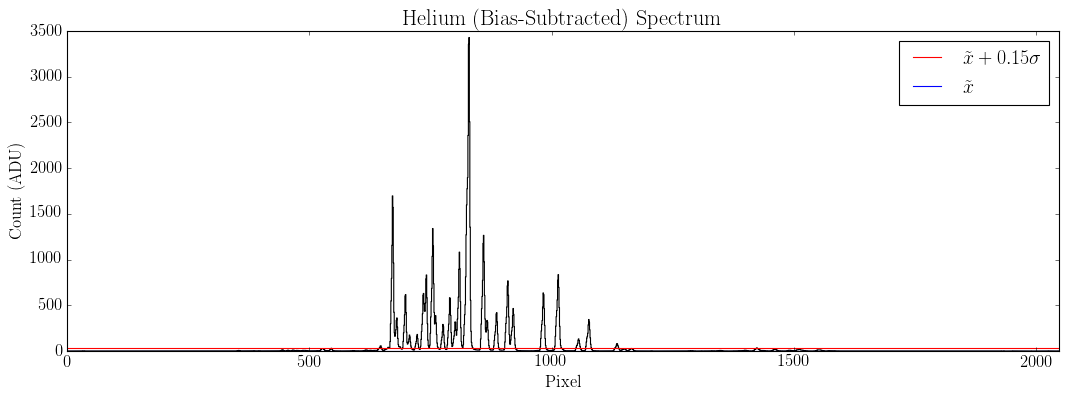

In [6]:
data = read_data('/home/jess/Desktop/Academic/PHYS164/lab2/bias_subtracted/neonbs.txt')
emiss = emission(data, thres=.15, ylim=[0,3500], title='Helium (Bias-Subtracted) Spectrum')

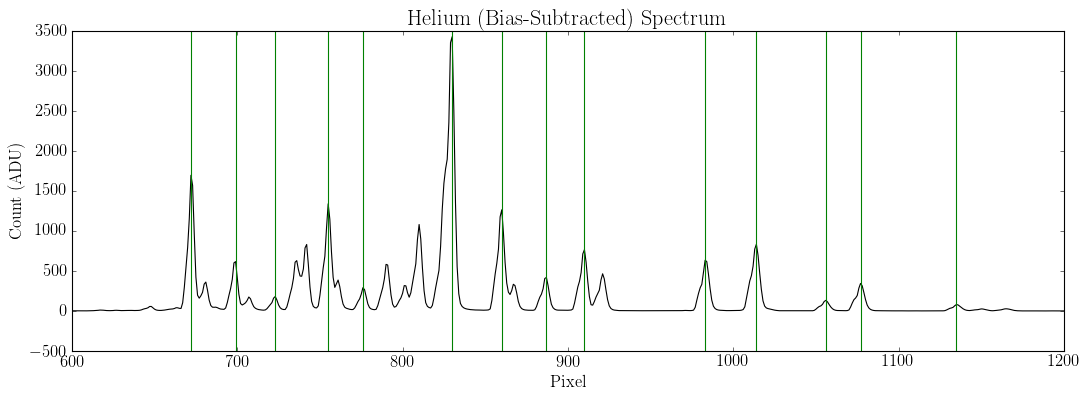

In [7]:
cent = centroid(data, emiss, xlim=[600,1200], title='Helium (Bias-Subtracted) Spectrum')

In [78]:
# for c in cent:
#     print(data[1][c])

In [12]:
he_arr = np.array([np.array(he_cal['spec_pixel']), np.array(he_cal['nist_wave'])])
ne_arr = np.array([np.array(ne_cal['spec_pixel']), np.array(ne_cal['nist_wave'])])

array([[ 132.   ,  289.   ,  412.   ,  438.   ,  678.   ,  908.   ,
        1021.   ,  673.712,  700.126,  722.492,  747.974,  775.796,
         820.02 ,  860.822,  886.09 ,  913.44 ,  982.83 , 1013.238,
        1134.814],
       [ 388.   ,  447.   ,  492.   ,  501.   ,  588.   ,  668.   ,
         706.   ,  585.25 ,  594.48 ,  602.99 ,  614.3  ,  621.73 ,
         640.22 ,  650.65 ,  659.9  ,  667.82 ,  692.94 ,  705.91 ,
         748.87 ]])

In [16]:
he_cal = pd.read_csv('wavecal/helium.csv')
ne_cal = pd.read_csv('wavecal/neon.csv')

xcal = np.array(he_cal['spec_pixel'])
ycal = np.array(he_cal['nist_wave'])

cal = np.concatenate((he_arr, ne_arr), axis=1)

[m,c] = linear_regression(cal[0], ycal[1])
print(m, c)

4.7711057478176855 -3519.4852614418132


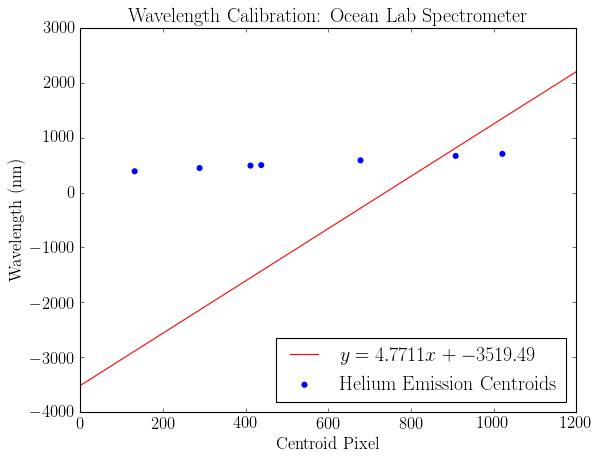

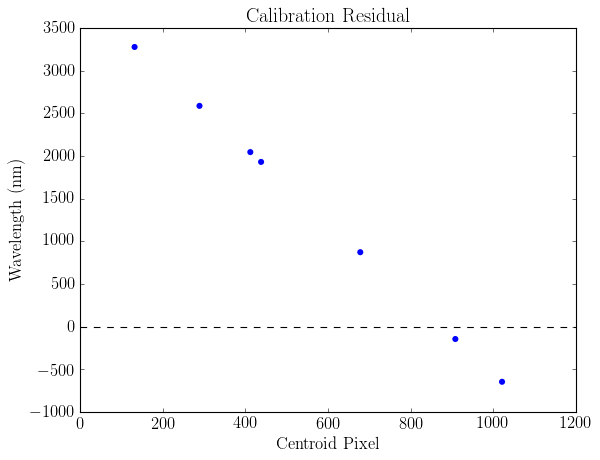

In [17]:
#==============
#Plot wavelength fit

xarr = np.arange(0,1200)
yarr = m*xarr + c

plt.scatter(xcal, ycal, edgecolor='none', s=30, label='Helium Emission Centroids')
plt.plot(xarr, yarr, color='r', label='$y=%s x + %s$'%(np.round(m,4), np.round(c,2)))

plt.xlim(xarr[0], xarr[-1])
plt.xlabel('Centroid Pixel')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Calibration: Ocean Lab Spectrometer')
plt.legend(loc='lower right', scatterpoints=1)
plt.savefig('writeup/plots/oceanlab_wavecal.png')
plt.show()

#==============
#Plot residuals
yfit = m*xcal + c

plt.scatter(xcal, ycal - yfit, edgecolor='none', s=30)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Centroid Pixel')
plt.ylabel('Wavelength (nm)')
plt.title('Calibration Residual')
plt.savefig('writeup/plots/oceanlab_residual.png')
plt.show()

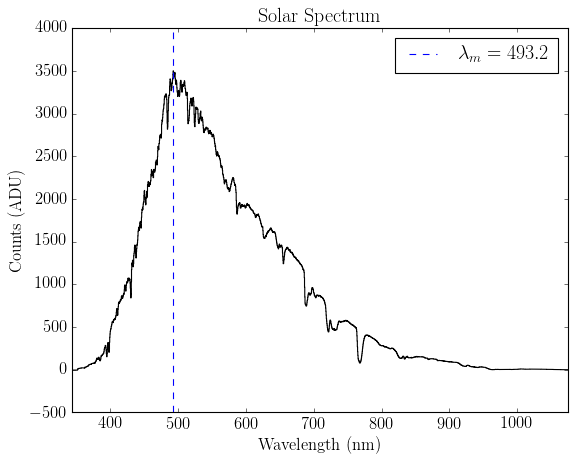

In [84]:
sp = read_data('bias_subtracted/sunbs.txt')
sp_wave = m*sp[0]+c
sp_flux = sp[1]

wave_max = sp_wave[np.where(sp_flux == max(sp_flux))[0][0]]

plt.step(sp_wave, sp_flux, color='k')
plt.axvline(wave_max, linestyle='--', label=r'$\lambda_m=%s$'%(np.round(wave_max,2)))
plt.xlim(min(sp_wave), max(sp_wave))
plt.title('Solar Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts (ADU)')
plt.legend(loc='upper right')
plt.savefig('writeup/plots/oceanlab_solar.png')
plt.show()

In [66]:
3*10**(-3)/(493*10**(-9))

6085.192697768763

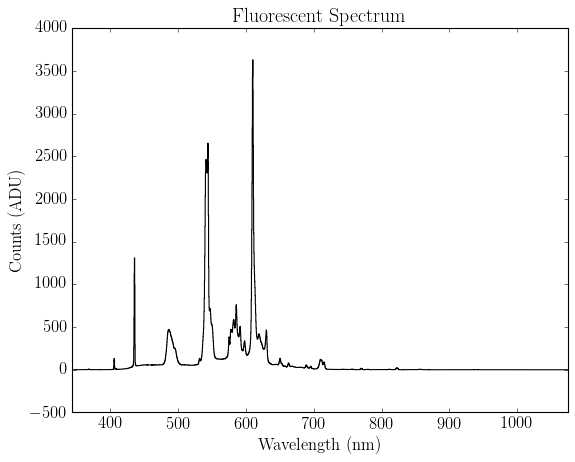

In [85]:
sp = read_data('bias_subtracted/flourescentbs.txt')
sp_wave = m*sp[0]+c
sp_flux = sp[1]

plt.step(sp_wave, sp_flux, color='k')
plt.xlim(min(sp_wave), max(sp_wave))
plt.title('Fluorescent Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts (ADU)')
plt.savefig('writeup/plots/oceanlab_fluorescent.png')
plt.show()

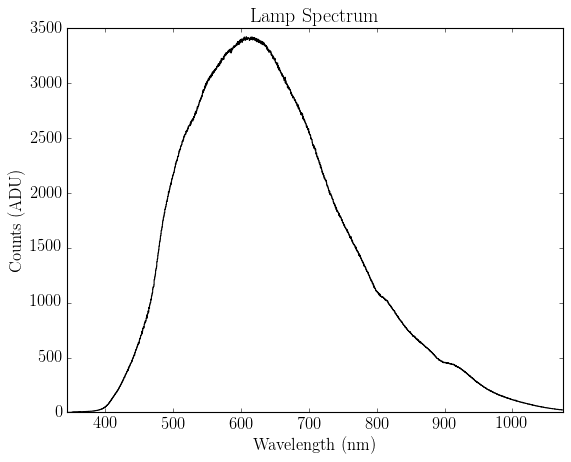

In [86]:
sp = read_data('bias_subtracted/lampbs.txt')
sp_wave = m*sp[0]+c
sp_flux = sp[1]

plt.step(sp_wave, sp_flux, color='k')
plt.xlim(min(sp_wave), max(sp_wave))
plt.title('Lamp Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts (ADU)')
plt.savefig('writeup/plots/oceanlab_lamp.png')
plt.show()

In [87]:
min(sp_wave), max(sp_wave)

(343.49360865290055, 1074.8525776092144)